In [2]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import mne

In [3]:
#Takes a period as list of samples, desired segment length in seconds and the sampling frequency, returns a list of segments of the period {{},{},...{}}
def splitperiod(period, segment_length, sampling_freq):
    segments = []
    current_segment = []
    sample_seglen = math(segment_length * sampling_freq)
    for i, sample in enumerate(period):
        current_segment.append(sample)
        if i%sample_seglen == 0 and i!=0:
            segments.append(current_segment)
            current_segment = []
    return segments

#############################YOO LOOKIE LOOKIE################################
# notis denna jäkel är snodd från nättet men efter patternet är taget så är det inte särskilt relevant att ha den
#############################YOO LOOKIE LOOKIE################################
def find_cluster(x, xval):
    """
    Find clusters of data in an ndarray that satisfy a certain condition.


    :param x: The array containing the data for the cluster search.
    :type x: ndarray

    :param xval: The value of x that has to be satisfied for clustering.
    :type xval: integer, float


    :returns: 2-tuple

        * i0:
            The index of each cluster starting point.

        * clustersize:
            The corresponding lengths of each cluster.

    :rtype: (list, list)


    Example
    -------
        >>> x = np.int32(np.round(np.random.rand(20)+0.1))
        >>> i0, clustersize = find_cluster(x, 1)

    """
    # Cluster information list
    a = []
    # Initial (place holder) values for cluster start and end points
    kstart = -1
    kend = -1
    # Going through each value of x
    for i, xi in enumerate(x):
        if xi == xval:
            # Assigning cluster starting point
            if kstart == -1:
                kstart = i
            # Assigning cluster end point for particular case
            # when there is an xval in the last position of x
            if i == len(x)-1:
                kend = i
        else:
            # Assigning cluster end point
            if kstart != -1 and kend == -1:
                kend = i-1
        # Updating cluster information list
        # and resetting kstart and kend
        if kstart != -1 and kend != -1:
            a.append(kstart)
            a.append(kend)
            kstart = -1
            kend = -1
    # Assigning indeces of cluster starting points
    # (Every other list element starting from position 0)
    i0 = a[0:-1:2]
    # Assigning cluster sizes
    # (Every other list element starting from position 1)
    clustersize = list(np.array(a[1::2]) - np.array(i0) + 1)
    # Case where cluster size is ZERO
    if len(i0) == 0:
        i0 = []
        clustersize = []
    return i0, clustersize


Extracting EDF parameters from d:\Epilepsi spike detection\Data\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\johan\AppData\Local\Temp\ipykernel_10280\2444525199.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()


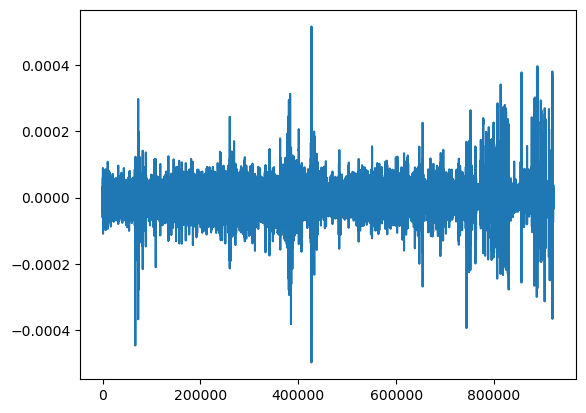

In [4]:
#loads data
raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()
plt.plot(raw_data[1])

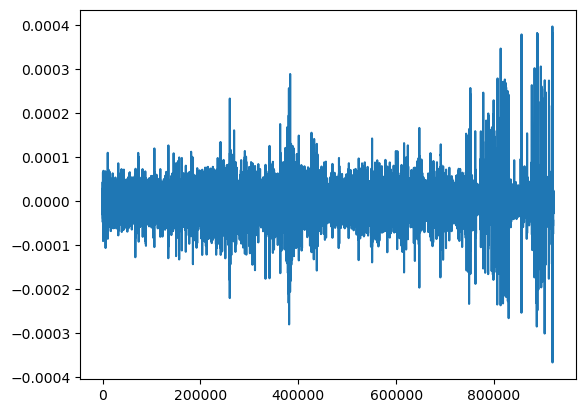

In [5]:
#filters the data
sos = scipy.signal.butter(20, 10, 'lp', fs=256, output='sos')
filtered = scipy.signal.sosfilt(sos, raw_data[1])
plt.plot(filtered)

8717


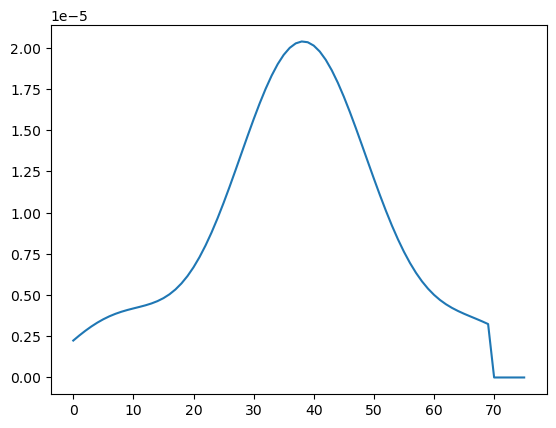

In [9]:
Spike_threshold = 0.000001
#stores the index where the signal starts (i0) going over a certain treshold and the length of that part of the signal (clustersize)
i0, clustersize = find_cluster(filtered<Spike_threshold, 0)

#picks out the peaks that meet the time criteria 
i0_spikes = []
spike_cluster = []
for i,size in enumerate(clustersize):
    if size > np.floor(256*0.02) and size < np.floor(256*0.07):
        spike_cluster.append(size)
        i0_spikes.append(i0[i])

# extracting a 0.3 seconds around the spike so as to have the full spike and wave form
time_to_extract = 0.3*256
extracted = []
for n,val in enumerate(clustersize):
    extracted_spike = filtered[math.floor((i0[n]+clustersize[n]*0.5)-time_to_extract*0.5):math.floor((i0[n]+clustersize[n]*0.5)+time_to_extract*0.5)]
    extracted.append(extracted_spike)
       
##### modul insat för att ta bort negativa spikar
### för akivering 
    
means = []
for mean in extracted:
    means.append(np.mean(mean))
    
saved_extracted = []
for i,mean in enumerate(means):
    if mean > means[9]:
        saved_extracted.append(extracted[i])   
    
###########    för aktivering av modul sätt deta kriterie till 1 
Bool = 1
if Bool ==1:
    extracted = saved_extracted 
    
# scaled signal averager, takes n signals and averages them to 1 signal that is a average of all of them.
#
Sum = [[0]*int(time_to_extract)]
Sum = Sum[0]
signal = []
for n in extracted:
    signal.append(n)

N = len(signal)

truth = N-1

i = 0
while i < 70:  
    n = 0
    while n < truth:
        Sum[i] = Sum[i] + signal[n][i]
        n +=1
    Sum[i] = Sum[i]/N
    i += 1
plt.plot(Sum)
print(len(extracted))

spikes found =5223


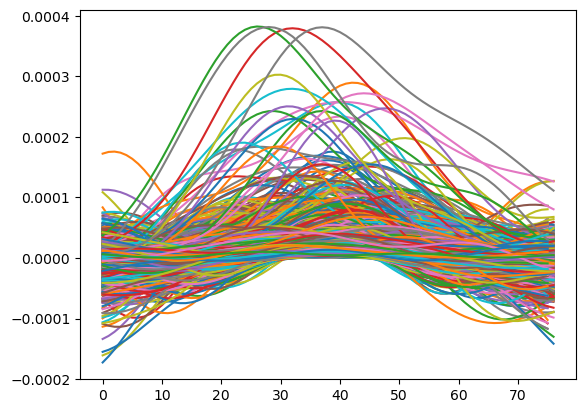

In [7]:

#############################YOO LOOKIE LOOKIE################################
# matching filter whit Least square method

threshold_score = []
for part in extracted:
    f = Sum
    y =  part
    
    a1 = 0
    a2 = 0
    a3 = 0
    a4 = 0
    a5 = 0
    a6 = 0
    N = len(y)

    t = 0
    #a calculations
    while t < N-1:
        a1 = a1 + f[t] * y[t]
        a2 = a2 + f[t]
        a3 = a3 + y[t]/N  
        a4 = a4 + math.pow(f[t],2)
        a5 = a5 + f[t]
        a6 = a6 + f[t]/N
        t += 1
        
    a = (a1-a2*a3)/(a4-a5*a6)

    b1 = 0
    b2 = 0
    t = 0
    #b calculations
    while t < N-1: 
        b1 = b1 + y[t]
        b2 = b2 + f[t]
        t += 1    

    b = b1 - a*b2

    t = 0
    yhat1 = []
    while t < N-1:
        yhat = a*f[t] + b
        yhat1.append(yhat1)
        se1 = math.pow((y[t] - yhat),2)
        t += 1
    SE = math.sqrt(se1/(N-1))

    criterion_score = a/SE
    threshold_score.append(criterion_score)

##############################################
#criterion for the least square fit 
threshold_least_squared = 10217

saved_index = []
for i,criterion in enumerate(threshold_score):
    if criterion >= threshold_least_squared:
        saved_index.append(i)


#############prints,plots and extracts#############

# prints how many spikes that are there
print("spikes found =" + str(len(saved_index)))    

# extracts these spikes 
Spikes_present = []
for index in saved_index:
    Spikes_present.append(extracted[index])    

# Plots spikes
for Spikes in Spikes_present:
    plt.plot(Spikes)  